In [1]:
import os
import sys
import time

import numpy as np

from scipy import stats

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import Table
from astropy.io import fits

%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [2]:
import data_loaders
import detectability

# Load ELVIS and GALFA

In [3]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [4]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [5]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hall&Oates
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Zeus&Hera


/Users/erik/projects/m31-galfa/data_loaders.py:83: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


# Compute detectability and findability for GALFA

In [6]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

for tab in elvii_pairs.values():
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [7]:
detectability.compute_elvis_mgas_bradford_15(elvii_pairs)

In [8]:
detectability.compute_elvis_detectability(galfa_sens, galfa_sens_wcs, 'dr1', elvii_pairs)

In [9]:
wakker_hvcs = Table.read('wakk.fits')
wakker_scs = SkyCoord(l=wakker_hvcs['L'], b=wakker_hvcs['B'], unit=u.deg, frame='galactic')

detectability.compute_elvis_findable(elvii_pairs, wakker_scs, wakker_hvcs['VLSR']*u.km/u.s)

# And figure out how to map halos to high-z 

In [10]:
for name, tree in elvii_trees.items():
    for z_re in (6,7,8,9):
        idxzre = np.argmin(np.abs(tree[0]['z']-z_re))    
        elvii_pairs[name]['Mviratz{}'.format(z_re)] = tree['Mvir'][:, idxzre]
        elvii_pairs[name]['Vmatz{}'.format(z_re)] = tree['Vmax'][:, idxzre]

# Set up counts parameters 

In [11]:
def counts_with_cutoffs(Mviratzre=0*u.solMass, z_re=8, appmagcut=100*u.mag, inclsat=False):
    counts = []
    for pair in elvii_pairs.values():
        halos = pair[2:]
        for i in (0, 1):
            matches = halos['findable_dr1_host{}'.format(i)]
            
            if Mviratzre is not None:
                matches = matches & (halos['Mviratz{}'.format(z_re)] > Mviratzre)
            
            dm = Distance(halos['host{}_dist'.format(i)]).distmod
            appmag = -2.5*np.log10(halos['Mstar_preferred']/u.solMass)*u.mag + dm 
            matches = matches & (appmag < appmagcut)
            
            if not inclsat:
                matches = matches & ~halos['sat_of_either']
                
            counts.append(np.sum(matches))
    return np.array(counts)

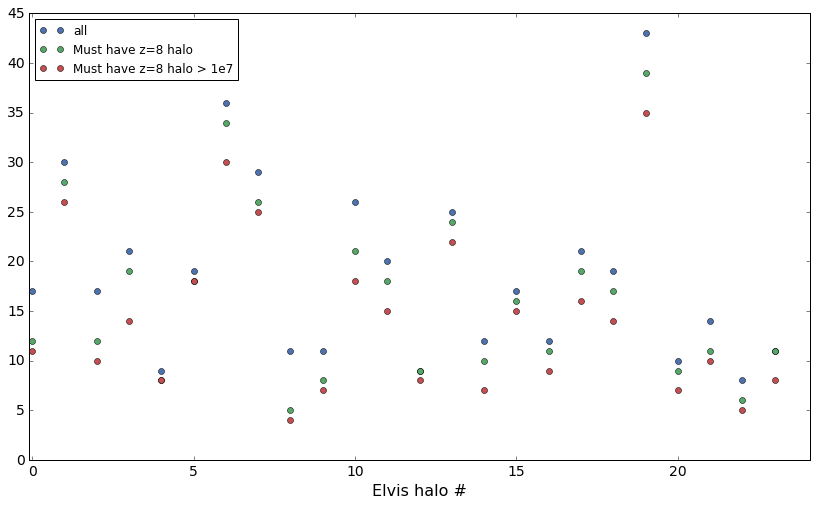

In [12]:
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None), 'o', label='all')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(), 'o', label='Must have z=8 halo')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(1e7*u.solMass), 'o', label='Must have z=8 halo > 1e7')

plt.xlim(-.1,len(elvii_pairs)*2 + .1)
plt.legend(loc=0)

plt.xlabel('Elvis halo #')

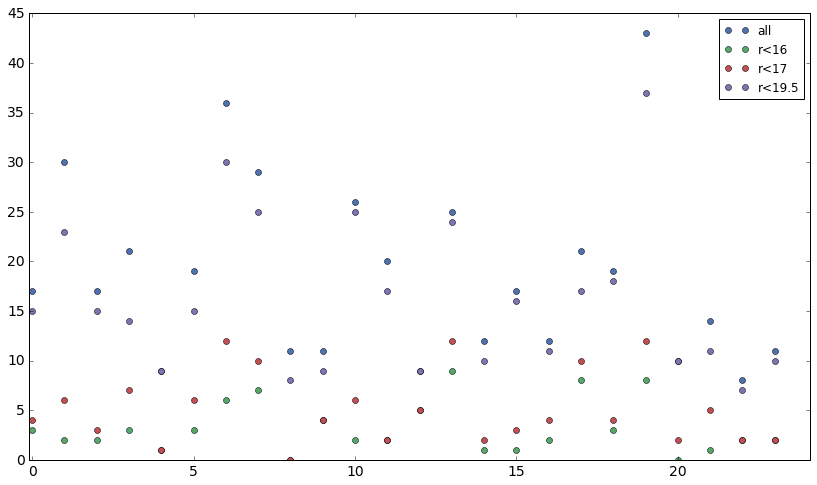

In [13]:
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None), 'o', label='all')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(16-4.7)*u.mag), 'o', label='r<16')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(17-4.7)*u.mag), 'o', label='r<17')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(19.5-4.7)*u.mag), 'o', label='r<19.5')

plt.xlim(-.1,len(elvii_pairs)*2 + .1)
plt.legend(loc=0)

# Now start doing inference

In [14]:
import emcee
import corner

In [15]:
PARAMETERS = ['logmvcut', 'zre', 'rmagcut']
MINF = -np.inf

def lnprior(logmvcut, zre, rmagcut):
    if not (5.5 < zre < 9.5):
        return MINF
    if not (8 < rmagcut < 22):
        return MINF
    if not (5 < logmvcut < 10.5):
        return MINF
    return 0

def get_p0(logmvcut, zre, rmagcut, dosmoothing, ncounts=0):
    appmagcut = (rmagcut - 4.7)*u.mag # appropriate for ~r with M/L=1
    
    counts = counts_with_cutoffs(Mviratzre=10**logmvcut * u.solMass, z_re=int(round(zre)), 
                                 appmagcut=appmagcut, inclsat=False)
    if np.sum(counts)==0:
        return float(ncounts==0)
    elif dosmoothing:
        kde = stats.gaussian_kde(counts, 'scott')
        ns = np.arange(round(np.max(counts)*1.5))
        ps = kde(ns)
        return ps[ncounts]/np.sum(ps)
    else:
        return np.sum(counts==ncounts)/len(counts)
    
def lnprob(pars, dosmoothing):
    logmvcut, zre, rmagcut = pars
    
    lpri = lnprior(logmvcut, zre, rmagcut)
    if lpri == MINF:
        return MINF
    
    return lpri + np.log(get_p0(logmvcut, zre, rmagcut, dosmoothing))

lnprob((7, 8, 17), True), lnprob((7, 8, 17), False)

(-2.7359829272089526, -3.1780538303479458)

## No Smoothing 

In [16]:
nwalkers = 10
nsamp = 1500

sampler = emcee.EnsembleSampler(nwalkers , len(PARAMETERS), lnprob, args=[False])
p0 = emcee.utils.sample_ball([7, 8, 17], [.1, .1, .1], size=nwalkers)

In [17]:
st = time.time()
sampler.run_mcmc(p0, 10)
et = time.time()

tmul = (et-st)*nsamp/10
print('10 samples took', et - st, 'sec', 'so', nsamp, 'samples will take', tmul, 'sec /', tmul/60,'min')

sampler.reset()

10 samples took 7.401578903198242 sec so 1500 samples will take 1110.2368354797363 sec / 18.503947257995605 min


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log


In [18]:
res = sampler.run_mcmc(p0, nsamp)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


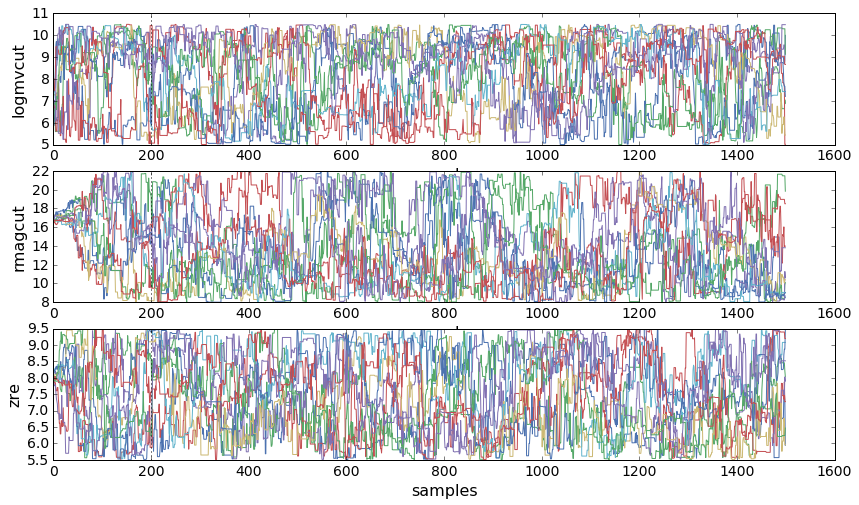

In [19]:
burnin = 200

ipl = 0
for i in (0,2,1):
    ipl += 1
    plt.subplot(sampler.chain.shape[-1], 1, ipl)
    plt.plot(sampler.chain.T[i])
    plt.axvline(burnin, c='k',ls=':')
    
    plt.xlabel('samples')
    plt.ylabel(PARAMETERS[i])
    
burned_flatchain = sampler.chain[:,burnin:, :]
burned_flatchain = burned_flatchain.reshape(burned_flatchain.size/burned_flatchain.shape[-1], burned_flatchain.shape[-1])

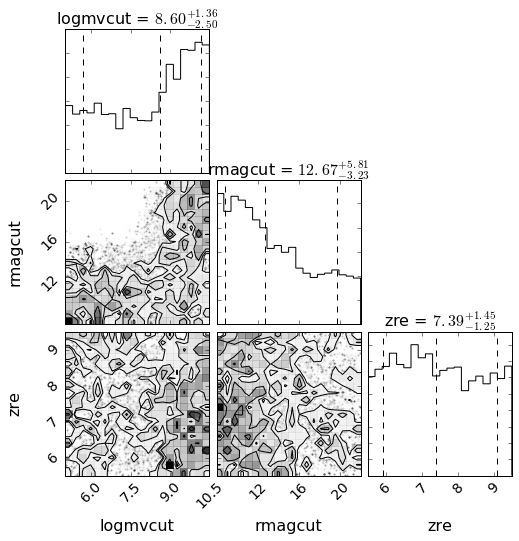

In [20]:
iorder = [0,2,1]

repar = [PARAMETERS[i] for i in iorder]

corner.corner(burned_flatchain[:, [0,2,1]], labels=repar, quantiles=[.1,.5,.9], show_titles=True)
None

## GKDE-smoothing 

In [21]:
nwalkers = 10
nsamp = 1500

samplers = emcee.EnsembleSampler(nwalkers , 3, lnprob, args=[True])
p0 = emcee.utils.sample_ball([7, 8, 17], [.1, .1, .1], size=nwalkers)

In [22]:
st = time.time()
sampler.run_mcmc(p0, 10)
et = time.time()


tmul = (et-st)*nsamp/10
print('10 samples took', et - st, 'sec', 'so', nsamp, 'samples will take', tmul, 'sec /', tmul/60,'min')

sampler.reset()

10 samples took 7.962032079696655 sec so 1500 samples will take 1194.3048119544983 sec / 19.905080199241638 min


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log


In [23]:
ress = samplers.run_mcmc(p0, nsamp)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


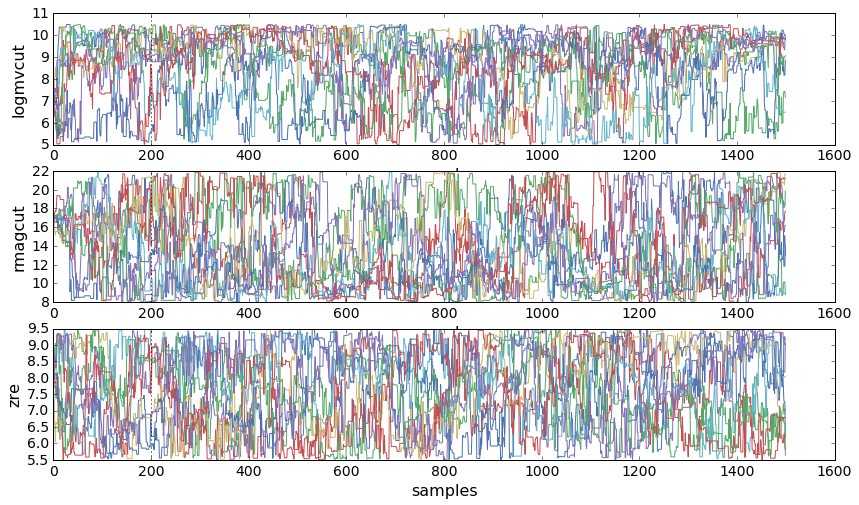

In [24]:
burnin = 200

ipl = 0
for i in (0,2,1):
    ipl += 1
    plt.subplot(samplers.chain.shape[-1], 1, ipl)
    plt.plot(samplers.chain.T[i])
    plt.axvline(burnin, c='k',ls=':')
    
    plt.xlabel('samples')
    plt.ylabel(PARAMETERS[i])
    
burned_flatchain = samplers.chain[:,burnin:, :]
burned_flatchain = burned_flatchain.reshape(burned_flatchain.size/burned_flatchain.shape[-1], burned_flatchain.shape[-1])

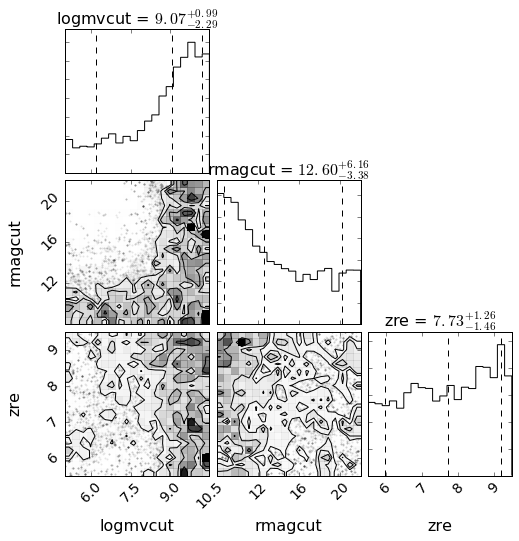

In [25]:
iorder = [0,2,1]

repar = [PARAMETERS[i] for i in iorder]

corner.corner(burned_flatchain[:, [0,2,1]], labels=repar, quantiles=[.1,.5,.9], show_titles=True)
None

Andrew's suggestions to try:
* add .3 dex scatter to SMHMR
* use past upID!=-1 instead of "is sat now"